In [1]:
import numpy as np
import pandas as pd
import torch
import math
from io import BytesIO
from zipfile import ZipFile
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns

In [2]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
%config Completer.use_jedi = False

### Load Dataset

In [4]:
DATASET = "FordA"
NUM_KERNELS = 1000
CONV_KERNELS = [7, 9, 11]

In [5]:
with ZipFile(f"{DATASET}.zip") as f:
    test = pd.read_table(BytesIO(f.read(f"{DATASET}/{DATASET}_TEST.tsv")), header=None)
    train = pd.read_table(BytesIO(f.read(f"{DATASET}/{DATASET}_TRAIN.tsv")), header=None)

In [50]:
def prepare_rocket_features(time_series, num_kernels, conv_kernels, kernels=None) -> (np.ndarray, np.ndarray, np.ndarray):
    
    y = (time_series.iloc[:, 0].values + 1) / 2
    X = time_series.iloc[:, 1:].values
    ts_tensor = torch.from_numpy((X - X.mean(axis=1, keepdims=True)))
    
    num_instances = len(y)
    ts_length = X.shape[1]
    features = np.ndarray(shape=(num_instances, num_kernels))
    
    if not kernels:
        # randomize new kernels
        kernels = []
        for i in range(num_kernels):
            conv_kernel_size = np.random.choice(conv_kernels)
            A = math.log((ts_length - 1) / (conv_kernel_size - 1), 2)
            conv_kernel_dilation = int(2**np.random.uniform(0, A))
            conv_padding = int(np.random.choice([0, ((conv_kernel_size - 1) * conv_kernel_dilation) / 2]))

            rand_conv = torch.nn.Conv1d(in_channels = 1, 
                                        out_channels = 1, 
                                        kernel_size = conv_kernel_size,
                                        stride=1, 
                                        padding = conv_padding,
                                        dilation = conv_kernel_dilation,
                                        groups=1,
                                        bias=True,
                                        padding_mode='zeros')
            rand_conv.weight.data = torch.nn.Parameter(torch.from_numpy(np.random.normal(size = conv_kernel_size).reshape(1, 1, -1)))
            kernels.append(rand_conv)
    
    for i, kernel in enumerate(kernels):
        out = kernel(ts_tensor.reshape(num_instances, 1, ts_length))
        ppv = (out>0).reshape(num_instances, -1).sum(axis=1) / ts_length
        features[:, i] = ppv
    
    return X, y, features, kernels

In [51]:
train_x, train_y, train_features, kernels = prepare_rocket_features(train, NUM_KERNELS, CONV_KERNELS)

In [53]:
test_x, test_y, test_features, _ = prepare_rocket_features(test, NUM_KERNELS, CONV_KERNELS, kernels)

In [54]:
log_reg = linear_model.LogisticRegression(max_iter=1000)

In [55]:
log_reg.fit(train_features, train_y)

LogisticRegression(max_iter=1000)

In [56]:
test_pred = log_reg.predict(test_features)
train_pred = log_reg.predict(train_features)

In [57]:
cm = metrics.confusion_matrix(test_y, test_pred)
cm

array([[616,  65],
       [ 64, 575]])

In [58]:
score = log_reg.score(test_features, test_y)
print(score)

0.9022727272727272


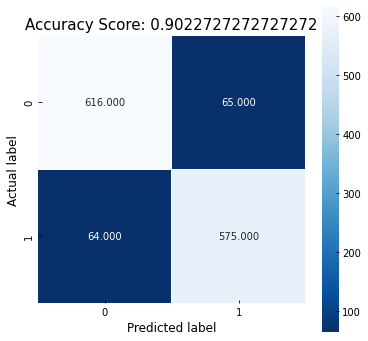

In [59]:
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Accuracy Score: {score}'
plt.title(all_sample_title, size = 15);